# U'n'Eye: Convolutional Neural Network for eye movement detection

Call the model with uneye.DNN(sampfreq) and then run training / testing / prediction with the method model.train(), model.test() or model.predict(), respectively.

Optional input arguments when calling uneye.DNN() are:
- min_sacc_dur: minimum saccade duration (in ms) for removal of small saccades (post-processing), default: 1==no removal
- min_sacc_dist: minimum distance (in ms) between two saccades for merging of close-by saccades, default: 1==no merge
- weights_name: filename for storage of trained weights. All trained weights will automatically be safed in the local folder 'training'. The default filename is 'weights'
- augmentation: True or False. Whether data augmentation (rotation of signal) should be used. The default is 'True'.
- ks: kernel size of convolutional layers. Has to be odd. Default: 5
- mp: size of max pooling window. Has to be odd. Default: 5
- inf_correction: Float value to replace infs or NaNs in differentiated input data (i.e. eye velocity). Should correspond to maximum value that is expected. Default: 1.5
- val_samples: Number of trials used for validating when to stop training early. Default: 30

# Training

Train network with own training data (example data in folder 'data').

For training, 3 inputs are **necessary**:
    - horizontal eye position (in deg)
    - vertical eye position (in deg)
    - ground truth labels for saccades (encoded as 1). Fixation encoded as 0. Additional labels are optional (e.g. post-saccadic oscillation, encoded as 2 etc.)
    
    
**model.train(X,Y,Labels)**   

In [1]:
##################################
########### Parameters ###########
datapath = 'data/Synthetic/'
min_sacc_dur = 6 #minimum saccade duration in ms
min_sacc_dist = 10 #minimum saccade distance in ms
sampfreq = 1000 #Hz
weights_name = 'weights_synthetic'

########### YOUR DATA ############
datapath = 'data/Synthetic' #folder with example data
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'
labels_filename = 'Labels_1000hz.csv'
##################################

In [2]:
import numpy as np
import uneye
import scipy.io as io
from os.path import join

In [3]:
# load synthetic example data (.csv)
Xtrain = np.loadtxt(join(datapath,x_filename),delimiter=',')
Ytrain = np.loadtxt(join(datapath,y_filename),delimiter=',')
Ltrain = np.loadtxt(join(datapath,labels_filename),delimiter=',')

# example dataset is large, so use only subset for training:
ntrain = 300 #samples for training
Xtrain = Xtrain[:ntrain,:]
Ytrain = Ytrain[:ntrain,:]
Ltrain = Ltrain[:ntrain,:]

# load .mat example data
#Xtrain,Ytrain,Ltrain = io.loadmat(datapath+'X_train.mat')['X'],io.loadmat(datapath+'Y_train.mat')['Y'],io.loadmat(datapath+'Sacc_train.mat')['Sacc']

# fit model on training data
# weights will automatically be saved to local folder 'training'
# call model with optional arguments


In [7]:
model = uneye.DNN(sampfreq=sampfreq,
                  weights_name=weights_name,
                  min_sacc_dur=min_sacc_dur,
                  min_sacc_dist=min_sacc_dist)
model.train(Xtrain,Ytrain,Ltrain)

Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 98 before overfitting occurred.
Model parameters saved to ./training\weights_synthetic


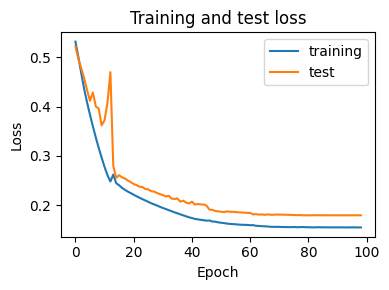

In [8]:
# plot loss
import matplotlib.pyplot as plt
f = plt.figure(figsize=(4,3))
plt.plot(model.loss_train,label='training')
plt.plot(model.loss_val,label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test loss')
plt.legend()
plt.tight_layout()
plt.show()

### Test after training network
Test performance with separate test data (here, synthetic example data is used).


For testing, 3 inputs are **necessary**:
    - horizontal eye position (in deg)
    - vertical eye position (in deg)
    - ground truth labels for saccades (encoded as 1). Additional labels are optional (e.g. post-saccadic oscillation, encoded as 2 etc.)    
  
**model.test()**

If you just trained the network before, you can directly apply **model.test()** to the trained model. Otherwise you have to specify the correct weights_name.

In [9]:
########### YOUR DATA ############
datapath = 'data/Synthetic/' #example data
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'
labels_filename = 'Labels_1000hz.csv'
##################################

# load example test data
Xtest = np.loadtxt(join(datapath,x_filename),delimiter=',')
Ytest = np.loadtxt(join(datapath,y_filename),delimiter=',')
Ltest = np.loadtxt(join(datapath,labels_filename),delimiter=',')

# reduce data to subset that wasn't used for training (only needed for this example)
Xtest = Xtest[ntrain:,:]
Ytest = Ytest[ntrain:,:]
Ltest = Ltest[ntrain:,:]

# test performance (here on subset of data that wasn't used for training)
Prediction,Probability,Performance = model.test(Xtest,Ytest,Ltest)

Binary Cohens Kappa:  0.963
F1: 0.983


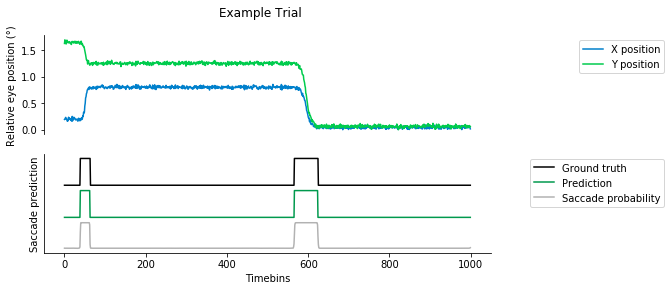

In [10]:
# plot example
i = np.random.randint(Xtest.shape[0])
fig = plt.figure(figsize=(8,4))
plt.suptitle('Example Trial')
ax = fig.add_subplot(211)
x_trace = Xtest[i,:] - np.min(Xtest[i,:])
y_trace = Ytest[i,:] - np.min(Ytest[i,:])
plt.plot(x_trace,label='X position',c=[0,0.5,0.8])
plt.plot(y_trace,label='Y position',c=[0,0.8,0.3])
plt.xticks(())
plt.ylabel('Relative eye position (°)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.legend(bbox_to_anchor=(1.4,1))

# prediction
ax = fig.add_subplot(212)
plt.plot(Ltest[i,:]+2.4,label='Ground truth',c='k')
plt.plot(Prediction[i,:]+1.2,label='Prediction',c=[0,0.6,0.3])
plt.plot(Probability[i,:],label='Saccade probability',c='k',alpha=.3)
plt.yticks(())
plt.ylabel('Saccade prediction')
plt.xlabel('Timebins')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1.4,1))
plt.show()

# Saccade prediction with pretrained network
Predict eye-movements in data (synthetic example data in folder 'data').


For prediction, 3 inputs are **necessary**:
    - horizontal eye position (in deg)
    - vertical eye position (in deg)
    - sampling frequency of the eye tracker
    
  
Call the model with at least two arguments **ueye.DNN(sampfreq,weights_name)** and then run prediction with the method **model.predict()**

In [3]:
import numpy as np

##################################
########### Parameters ###########
sampfreq = 1000 #Hz
weights_name = 'weights_synthetic'
min_sacc_dur = 6 # in ms
min_sacc_dist = 10 #in ms

########### YOUR DATA ############

datapath = 'data/Synthetic/' #example data
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'

##################################
##################################

# load data
Xtest = np.loadtxt(join(datapath,x_filename),delimiter=',')
Ytest = np.loadtxt(join(datapath,y_filename),delimiter=',')


In [3]:
Xtrain = np.loadtxt('data\predict_gaze.csv',delimiter=',')[:,1].reshape(-1,1)
Ytrain = np.loadtxt('data\predict_gaze.csv',delimiter=',')[:,2].reshape(-1,1)

In [13]:
Xtrain.shape

(82, 1)

In [4]:
import uneye
# Prediction
model = uneye.DNN(weights_name=weights_name,
                 sampfreq=sampfreq,
                 min_sacc_dur=min_sacc_dur,
                min_sacc_dist=min_sacc_dist)
Prediction,Probability = model.predict(Xtrain,Ytrain)

RuntimeError: Calculated padded input size per channel: (4 x 2). Kernel size: (5 x 2). Kernel size can't be greater than actual input size

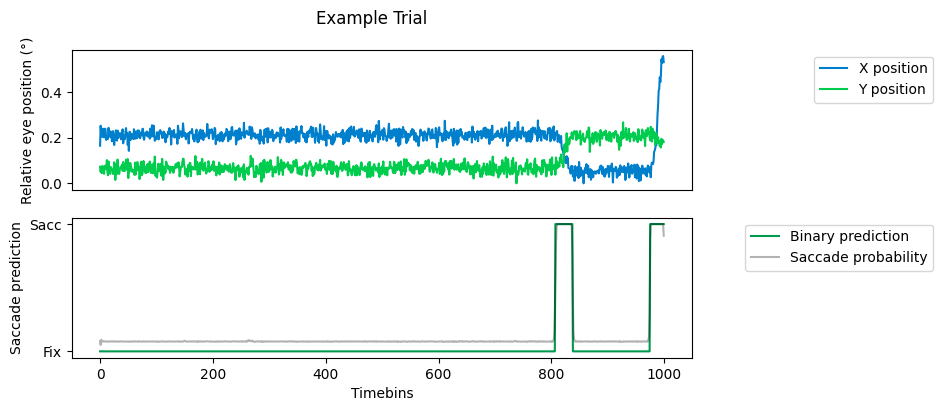

In [8]:
import matplotlib.pyplot as plt
# plot example
i = np.random.randint(Xtest.shape[0])
fig = plt.figure(figsize=(8,4))
plt.suptitle('Example Trial')
ax = fig.add_subplot(211)
x_trace = Xtest[i,:] - np.min(Xtest[i,:])
y_trace = Ytest[i,:] - np.min(Ytest[i,:])
plt.plot(x_trace,label='X position',c=[0,0.5,0.8])
plt.plot(y_trace,label='Y position',c=[0,0.8,0.3])
plt.xticks(())
plt.ylabel('Relative eye position (°)')
plt.legend(bbox_to_anchor=(1.4,1))

# prediction
ax = fig.add_subplot(212)
plt.plot(Prediction[i,:],label='Binary prediction',c=[0,0.6,0.3])
plt.plot(Probability[i,1,:],label='Saccade probability',c='k',alpha=.3)
plt.yticks((0,1),['Fix','Sacc'])
plt.ylabel('Saccade prediction')
plt.xlabel('Timebins')
plt.legend(bbox_to_anchor=(1.4,1))
plt.show()